In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras,os
import csv
from tensorflow.python.client import device_lib
import numpy as np
print(device_lib.list_local_devices())
print(tf.__version__)



trdata  = ImageDataGenerator(rotation_range=15,rescale=1.0/255.0,height_shift_range=0.15,width_shift_range=0.15,fill_mode="constant")#,validation_split=0.2)
traindata = trdata.flow_from_directory(directory="orientation/train",target_size=(224,224))#, subset="training")
#valdata = trdata.flow_from_directory(directory="orientation/train",target_size=(224,224), subset="validation")
tsdata = ImageDataGenerator(rescale=1.0/255.0)
testdata = tsdata.flow_from_directory(directory="orientation/test", target_size=(224,224))


# In[5]:


#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
## Loading VGG16 model



# In[6]:





# In[7]:


from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
with strategy.scope():#using multiple gpus to train
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3)) #TODO change input shape
    #base_model.trainable = False 
    for layer in base_model.layers[:-2]:
            layer.trainable = False
            ## Not trainable weights
    base_model.summary()
    #resizing_layer = layers.Resizing(224,224)
    #normalization_layer = tf.keras.layers.Normalization(mean = 0 , variance = 1 )
    input_layer=layers.Input(shape=(224,224,3))
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(4096, activation='relu')
    dense_layer_2 = layers.Dense(1024, activation='relu')
    dropout_layer=layers.Dropout(0.2)
    prediction_layer = layers.Dense(2, activation='softmax')


    model = models.Sequential([
        #resizing_layer,
        #normalization_layer,
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        dropout_layer,
        prediction_layer
    ])
    model.summary()

    # In[8]:



    opt= tf.keras.optimizers.Adam(learning_rate=0.0001) #TODO change learning rates
    model.compile(
        opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

def custom_lr(epoch,lr):
    if epoch<5:
        return 0.001
    elif 4<epoch<10:
        return 0.0001
    else:
        return 0.00005
    
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=8,  restore_best_weights=True)
learningrate=LearningRateScheduler(custom_lr)
callbasck=[es,learningrate]
model.fit(traindata, epochs=20, callbacks=callbasck,validation_data=testdata)


# In[9]:


loss, accur = model.evaluate(testdata)
print(loss,accur)


# # In[10]:

#if(accur>0.95):
#    model.save("VGG19_transfer.model")


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4898016523362919275
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15354345961636989894
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17348623098493560507
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15031607495138439821
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17929179053272030752
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31741748224
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      de

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
37/37 [==============================] - 19s 520ms/step - loss: 685.6697 - accuracy: 0.5093 - val_loss: 0.6977 - val_accuracy: 0.5383 - lr: 0.0100
Epoch 2/20
37/37 [==============================] - 29s 797ms/step - loss: 0.7392 - accuracy: 0.4941 - val_loss: 0.6948 - val_accuracy: 0.4863 - lr: 0.0100
Epoch 3/20
37/37 [==============================] - 29s 793ms/step - loss: 0.7302 - accuracy: 0.5101 - val_loss: 0.7020 - val_accuracy: 0.4863 - lr: 0.0100
Epoch 4/20
17/37 [============>.................] - ETA: 12s - loss: 0.7538 - accuracy: 0.4982

KeyboardInterrupt: 

In [ ]:
model.save("VGG19_transfer3.model")

In [25]:
model = tf.keras.models.load_model('VGG19_transfer2.model')
from PIL import Image
src=os.getcwd()+"/resized_images3"
x_test=[]
for i in range(2949):
    A=Image.open(src+"/"+str(i)+".png")
    A=A.convert('RGB')
    A=np.array(A,dtype=np.float32)
    A/=255.0
    x_test.append(A)
x_test=np.array(x_test)
prediction = model.predict(x_test)
file=open("results.txt",'w')
for i in range(len(x_test)):
    file.write(str(i)+","+str(np.argmax(prediction[i]))+"\n")
g=0
d=0
for i in range(len(prediction)):
    if np.argmax(prediction[i])==0:
        g+=1
    else:
        d+=1
print(d/(d+g))
print(g/(d+g))
print(d/g)

0.5632417768735164
0.43675822312648355
1.2895962732919255


In [26]:
for i in range(len(prediction)):
    if np.argmax(prediction[i]) == 0:
        print(i)

3
4
5
16
20
24
25
26
27
28
29
31
33
38
39
42
44
46
50
51
52
55
56
60
65
66
67
80
81
82
83
93
95
96
97
98
105
121
122
123
124
125
127
144
145
146
153
155
156
157
159
168
169
171
172
175
176
177
178
181
183
187
188
189
190
191
192
193
194
207
217
218
219
220
221
222
223
224
225
227
229
232
237
238
239
240
244
245
252
253
261
262
263
264
265
266
267
273
282
291
292
293
295
296
304
305
306
307
308
312
320
321
322
330
331
334
338
339
340
341
342
343
344
345
347
348
351
352
353
354
357
360
361
366
367
368
369
370
371
372
373
374
375
376
380
381
383
384
385
386
389
394
395
396
397
407
408
421
422
423
424
425
426
427
428
429
430
431
432
433
435
436
454
455
456
472
473
474
475
476
479
480
481
482
483
484
485
488
489
490
491
492
493
499
500
501
504
505
506
507
520
536
537
538
539
540
541
545
546
547
548
552
553
554
555
556
561
562
565
566
571
575
576
580
581
589
590
591
592
595
611
612
618
625
626
628
629
630
631
632
635
644
645
646
651
652
653
654
655
656
657
661
666
667
668
669
670
671
672
673

In [27]:
print(prediction[0])

[0.02732565 0.9726743 ]


In [28]:
a,b=testdata.next()

In [29]:
print(type(a),type(b))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [30]:
print(b)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [31]:
import matplotlib.pyplot as plt

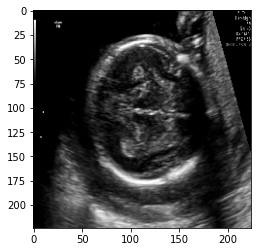

In [32]:
plt.imshow(a[5])

In [4]:
tsdata = ImageDataGenerator(rescale=1.0/255.0)
testdata = tsdata.flow_from_directory(directory="orientation/test", target_size=(224,224),shuffle=False)
model_preds = model.predict(testdata)
model_classes = np.argmax(model_preds, axis=1)
true_classes=testdata.classes

Found 366 images belonging to 2 classes.


2022-01-07 13:59:21.472299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-07 13:59:22.098936: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testdata.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax1 = plt.subplots(1,1)

plot_heatmap(true_classes, model_classes, class_names, ax1, title="Custom CNN")    
#plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

plt.show()


NameError: name 'testdata' is not defined

In [35]:
print(true_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [36]:
print(model_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [37]:
from sklearn import *
report = metrics.classification_report(true_classes, model_classes, target_names=class_names)
print(report)    

              precision    recall  f1-score   support

      droite       0.98      0.95      0.96       177
      gauche       0.95      0.98      0.97       189

    accuracy                           0.96       366
   macro avg       0.97      0.96      0.96       366
weighted avg       0.96      0.96      0.96       366



In [3]:
print(list(class_names))

NameError: name 'class_names' is not defined

In [1]:
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import csv
from tensorflow.python.client import device_lib
import numpy as np
#print(device_lib.list_local_devices())
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
## Loading VGG16 model

from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

Using TensorFlow backend.


In [3]:

model = tf.keras.models.load_model('VGG19_transfer2.model')
last_conv_layer = model.get_layer('vgg19').get_layer("block5_conv4")

2022-01-07 13:59:05.749966: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-07 13:59:05.907335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-07 13:59:05.908331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-07 13:59:05.909275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2

In [5]:
import seaborn as sns

In [50]:
def decodePrediction(A):
    return list(class_names)[np.argmax(A)]
def show_superimposed_image(img_path, heatmap):
    img = cv2.imread(img_path)
    img=cv2.resize(img,(224,224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap=255-heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.3 + img * 0.7
    print(np.max(superimposed_img))
    return superimposed_img


def process_image(img_path, idx=0):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    #gradModel = tf.keras.models.Model(inputs=[model.get_layer('vgg19').input,model.input],outputs=[last_conv_layer.output,model.output])
    #gradModel.summary()
    plt.imshow(img)
    plt.grid(False)
    plt.show()

    x = tf.keras.preprocessing.image.img_to_array(img)
    x/=255
    #x=[x,x]
    x = np.expand_dims(x, axis=0)
    with tf.GradientTape() as tape:

        last_conv_layer = model.get_layer('vgg19').get_layer("block5_conv4")
        convmodel=tf.keras.models.Model(inputs=model.inputs,outputs=last_conv_layer.get_output_at(1))
        classifier_input=tf.keras.layers.Input(shape=last_conv_layer.output.shape[1:])
        a=classifier_input
        a=tf.keras.layers.MaxPool2D()(a)
        for layer in model.layers[1:]:
            a=model.get_layer(layer.name)(a)
        classifier_model=tf.keras.models.Model(classifier_input,a)
        #print(model.output)
        #print(tape.watched_variables)
        #gradModel = tf.keras.models.Model(inputs=model.inputs,outputs=[last_conv_layer.get_output_at(1),model.output])
        #gradModel.summary()
        x = tf.cast(x, tf.float32)
        last_conv_layer=convmodel(x)
        tape.watch(last_conv_layer)
        #preds = model(x)
        #print('Predicted:', decodePrediction(preds))
        model_out=classifier_model(last_conv_layer)
        #class_index = np.argmax(preds)
        #print(np.argmax(model_out[0]))
        class_out = model_out[:, np.argmax(model_out[0])]
        #loss = preds[:, class_index]
        #print(tape.gradient(class_out, last_conv_layer))
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #grads = K.gradients(loss, last_conv_layer.output)[0]
    #grads = tape.gradient(loss, last_conv_layer)[0]

    #pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    #pooled_grads_value, conv_layer_output_value = iterate([x])
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    pooled_grads=pooled_grads.numpy()
    last_conv_layer=last_conv_layer.numpy()[0]
    for i in range(512):
        last_conv_layer[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    sns.heatmap(heatmap,cmap="jet",annot=True)

    A=show_superimposed_image(img_path, heatmap)
    A/=255
    plt.matshow(A)
    plt.show()

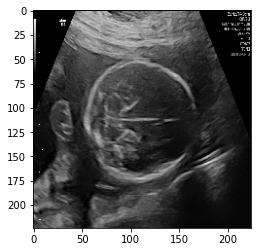

255.0


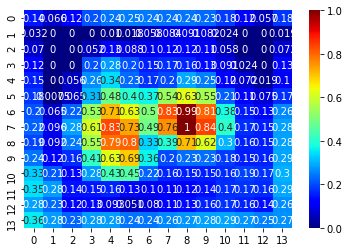

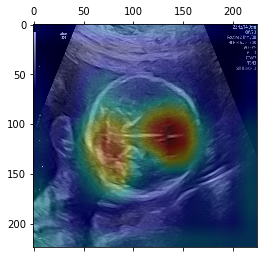

In [56]:
process_image("orientation/test/droite/1993.png")

In [155]:
last_layer=model.get_layer('vgg19').get_layer("block5_conv4")

In [156]:
last_layer.summary()

AttributeError: 'Conv2D' object has no attribute 'summary'

In [104]:
print(model.output[:,0])

Tensor("strided_slice_10:0", shape=(None,), dtype=float32)


In [106]:
print(K.gradients([1,0], last_conv_layer.output))

[None]


In [167]:
print(model.inputs)

[<tf.Tensor 'input_3_1:0' shape=(None, 224, 224, 3) dtype=float32>]


In [200]:
from keras.utils import plot_model 
plot_model(model)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [351]:
print(model.layers)

[<tensorflow.python.keras.engine.training.Model object at 0x7f84b0701400>, <tensorflow.python.keras.layers.core.Flatten object at 0x7f84b073b490>, <tensorflow.python.keras.layers.core.Dense object at 0x7f84b073ba00>, <tensorflow.python.keras.layers.core.Dense object at 0x7f84b073b4f0>, <tensorflow.python.keras.layers.core.Dropout object at 0x7f84b073bd90>, <tensorflow.python.keras.layers.core.Dense object at 0x7f84b073bee0>]


In [367]:
model2=layers.Flatten()(base_model(input_layer))
model2=layers.Dense(4096, activation='relu')(model2)
model2=layers.Dense(1024, activation='relu')(model2)
output=layers.Dense(2, activation='softmax')(model2)
model2=tf.keras.Model(input_layer,output)
model2.summary()


Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2050      
Total params: 126,986,306
Trainable params: 109,321,730
Non-trainable params: 17,664,576
___________________________________

In [400]:
last_layer=model.get_layer('vgg19').get_layer("block5_conv4")

In [401]:
print(last_layer.output)

Tensor("block5_conv4_6/Identity:0", shape=(None, 14, 14, 512), dtype=float32)


In [402]:
print(last_layer.get_output_at(1))

Tensor("vgg19_7/block5_conv4/Identity:0", shape=(None, 14, 14, 512), dtype=float32)
